In [19]:
import xarray as xr
import xmitgcm
import MITgcm_recipes
import tqdm
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [20]:
GLODAP_dir= '/local/data/artemis/observations/GLODAP_v2/originals/'
GLODAP_no3_ds = xr.open_dataset(GLODAP_dir + 'GLODAPv2.2016b.NO3.nc', decode_times=False)

In [21]:
GLODAP_no3_ds.lon

<xarray.DataArray 'lon' (lon: 360)>
array([ 20.5,  21.5,  22.5, ..., 377.5, 378.5, 379.5])
Coordinates:
  * lon      (lon) float64 20.5 21.5 22.5 23.5 24.5 ... 376.5 377.5 378.5 379.5
Attributes:
    units:        degrees east
    Description:  This number represents the mid-point of the 1x1 degree grid...

In [22]:
GLODAP_no3_ds.depth_surface

<xarray.DataArray 'depth_surface' (depth_surface: 33)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])
Dimensions without coordinates: depth_surface

In [23]:
#use depth_surface to visualize vertical levels

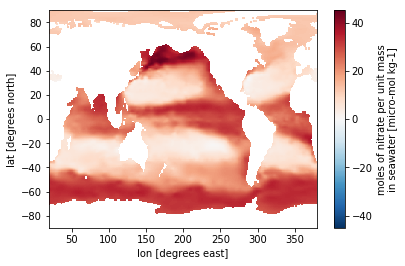

In [24]:
GLODAP_no3_ds['NO3'].sel(depth_surface=10).plot()

In [25]:
## Regrid from (0, 360) to (-180, 180)

In [26]:
def geo_roll_glodap_to_180(ds, londim):
    ind = (np.abs(ds[londim].values-180.)).argmin()
    ds = ds.roll(**{londim: -ind-1})
    datalon = np.mod(ds[londim].values, 360)
    datalon[np.where(datalon > 180)] -= 360
    ds[londim] = datalon
    return ds

In [27]:
GLODAP_no3_ds_180 = geo_roll_glodap_to_180(GLODAP_no3_ds, 'lon')

array([-89.5, -88.5, -87.5, -86.5, -85.5, -84.5, -83.5, -82.5, -81.5,
       -80.5, -79.5, -78.5, -77.5, -76.5, -75.5, -74.5, -73.5, -72.5,
       -71.5, -70.5, -69.5, -68.5, -67.5, -66.5, -65.5, -64.5, -63.5,
       -62.5, -61.5, -60.5, -59.5, -58.5, -57.5, -56.5, -55.5, -54.5,
       -53.5, -52.5, -51.5, -50.5, -49.5, -48.5, -47.5, -46.5, -45.5,
       -44.5, -43.5, -42.5, -41.5, -40.5, -39.5, -38.5, -37.5, -36.5,
       -35.5, -34.5, -33.5, -32.5, -31.5, -30.5, -29.5, -28.5, -27.5,
       -26.5, -25.5, -24.5, -23.5, -22.5, -21.5, -20.5, -19.5, -18.5,
       -17.5, -16.5, -15.5, -14.5, -13.5, -12.5, -11.5, -10.5,  -9.5,
        -8.5,  -7.5,  -6.5,  -5.5,  -4.5,  -3.5,  -2.5,  -1.5,  -0.5,
         0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
         9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
        18.5,  19.5,  20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,
        27.5,  28.5,  29.5,  30.5,  31.5,  32.5,  33.5,  34.5,  35.5,
        36.5,  37.5,

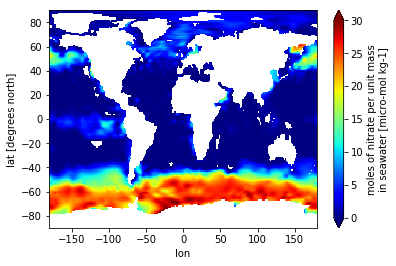

In [28]:
GLODAP_no3_ds_180['NO3'].isel(depth_surface=0).plot( vmin=0, vmax=30,cmap='jet')
GLODAP_no3_ds_180['NO3'].lat.values

## ASTE raw grid

In [29]:
file_aste_raw = '/local/data/artemis/workspace/rdussin/ASTE/GRID/nc/aste_grid.nc'
aste_raw = xr.open_dataset(file_aste_raw)

## ASTE output grid

In [30]:
datadir_aste = '/local/data/artemis/workspace/rdussin/ASTE/RUNS/ASTE-Phy-Release1/outputs/'
md = xmitgcm.utils.get_extra_metadata(domain='aste', nx=270)
aste_out = xmitgcm.open_mdsdataset(datadir_aste, iters=[], prefix=['T','S','Eta','U','V'],
                                   geometry='llc', nx=270, extra_metadata=md)

## Vertical interpolation

In [31]:
GLODAP_no3_dsz = MITgcm_recipes.vertical_interpolation(GLODAP_no3_ds_180, aste_out['Z'], ['NO3'],
                                                       lonvar='lon', latvar='lat',
                                                       depth_varin='depth_surface')

In [32]:
GLODAP_no3_dsz

<xarray.Dataset>
Dimensions:  (k: 50, lat: 180, lon: 360)
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    drF      (k) >f4 dask.array<shape=(50,), chunksize=(50,)>
    PHrefC   (k) >f4 dask.array<shape=(50,), chunksize=(50,)>
Data variables:
    Z        (k) >f4 dask.array<shape=(50,), chunksize=(50,)>
    NO3      (k, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan

## Regridding

In [33]:
GLODAP_no3_aste = MITgcm_recipes.regridding.regrid_2_mitgcm_llc(GLODAP_no3_ds_180, aste_raw, ['NO3'], 
                                                                method='bilinear',
                                                                lonname='lon', latname='lat', point='T', 
                                                                periodic=True, reuse_weights=False,
                                                                regridname='GLODAP_1deg_aste_face')

Overwrite existing file: GLODAP_1deg_aste_face0.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: GLODAP_1deg_aste_face1.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: GLODAP_1deg_aste_face2.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: GLODAP_1deg_aste_face3.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: GLODAP_1deg_aste_face4.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: GLODAP_1deg_aste_face5.nc 
 You can set reuse_weights=True to save computing time.


## Check results

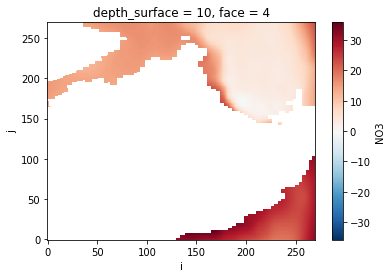

In [37]:
GLODAP_no3_aste['NO3'].isel(face=4, depth_surface=10).plot()

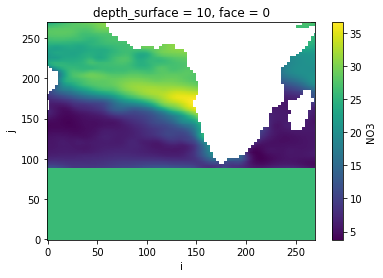

In [38]:
GLODAP_no3_aste['NO3'].isel(face=0, depth_surface=10).plot()